# Chains & Geography

In this notebook we conduct additional feature engineering to improve upon previous supervised models. We will derive the following:
- Is the business part of a chain?
- How does it compare to businesses within a 1 mile radius?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import Counter, OrderedDict
import utils, plot_help

%matplotlib inline

In [2]:
#download data
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=-1)

df_bus.head()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,cool_change,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,33.522143,-112.018481,Arizona Biltmore Golf Club,0,...,0.000000,0.00000,0.000000,0.000000,1.777778,2012-06-16 14:53:33,2016-06-18 16:22:16,5323,3.5,0
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",43.605499,-79.652289,Emerald Chinese Restaurant,1,...,-0.042484,-0.04902,-0.075163,-0.156863,36.083333,2010-07-05 16:56:31,2018-11-09 21:08:54,15143,3.0,1
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant,2,...,-0.110000,-0.19000,0.055000,-0.215000,57.083333,2010-11-13 01:00:36,2018-11-10 17:15:54,58518,3.5,1
3,"15655 W Roosevelt St, Ste 237",NaN,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",33.455613,-112.395596,Farmers Insurance - Paul Lorenz,3,...,0.000000,0.00000,0.000000,-0.500000,1.222222,2012-10-29 22:36:50,2016-04-27 00:57:54,8464,3.5,1
4,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': ""{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",43.599475,-79.711584,The UPS Store,5,...,0.000000,0.00000,0.000000,0.000000,1.000000,2014-03-31 21:46:17,2018-05-22 22:35:48,2971,3.0,1


In [3]:
#recall columns
print(*df_bus.columns, sep=', ')

address, attributes, business_id, categories, city, hours, latitude, longitude, name, postal_code, review_count, stars, state, road_type, GoodForKids, RestaurantsReservations, Caters, RestaurantsTableService, RestaurantsTakeOut, RestaurantsPriceRange2, OutdoorSeating, BikeParking, HasTV, RestaurantsGoodForGroups, RestaurantsDelivery, BusinessAcceptsCreditCards, BusinessAcceptsBitcoin, ByAppointmentOnly, AcceptsInsurance, GoodForDancing, CoatCheck, HappyHour, WheelchairAccessible, DogsAllowed, DriveThru, Corkage, BYOB, Open24Hours, RestaurantsCounterService, dessert, latenight, lunch, dinner, brunch, breakfast, garage, street, validated, lot, valet, romantic, intimate, classy, hipster, divey, touristy, trendy, upscale, casual, dj, background_music, no_music, jukebox, live, video, karaoke, monday, tuesday, friday, wednesday, thursday, sunday, saturday, straightperms, coloring, extensions, africanamerican, curly, kids, perms, asian, dairy_free, gluten_free, vegan, kosher, halal, soy_free,

# Chains

In [4]:
#get all names that are lower and duplicated
name_lower = df_bus['name'].str.lower().copy()

In [5]:
name_val_count = name_lower.value_counts(sort=True, ascending=False)

In [6]:
#see very very popular chains
name_val_count[:20]

starbucks                 1062
mcdonald's                 796
subway                     756
tim hortons                333
taco bell                  309
pizza hut                  302
burger king                301
walgreens                  301
wendy's                    292
the ups store              262
cvs pharmacy               258
circle k                   237
great clips                236
enterprise rent-a-car      206
domino's pizza             195
kfc                        186
dunkin' donuts             186
chipotle mexican grill     182
wells fargo bank           181
chase bank                 181
Name: name, dtype: int64

In [7]:
#see even less popular chains
name_val_count[(name_val_count.values==3)]

the face shop                           3
sunrise medical center                  3
jacobson bros meats & deli              3
lady janes haircuts for men             3
mec                                     3
nails of america                        3
mountain view park                      3
c-a-l ranch stores                      3
bubbles car wash                        3
the waterfront                          3
karsten's ace hardware                  3
fran's restaurant                       3
hopscotch                               3
tempe bicycle                           3
mirage grill & lounge                   3
girves brown derby                      3
carvel ice cream                        3
o'reily auto parts                      3
piza pizza                              3
ncounter                                3
the grill                               3
lucy activewear                         3
mad hatter mufflers & brakes            3
india palace                      

### Let a chain be any business that has at least 5 identical entires, this will leave out common names such as dumpling house. We understand that by definition just 2 locations or more make for a chain/franchise, however we want to only account for businesses that are relatively popular.

In [8]:
#get chain names
chain_names = name_val_count[(name_val_count.values>=5)].index.tolist()
#see samples
chain_names[:10]

['starbucks',
 "mcdonald's",
 'subway',
 'tim hortons',
 'taco bell',
 'pizza hut',
 'burger king',
 'walgreens',
 "wendy's",
 'the ups store']

In [9]:
def get_chain(bus_name, chain_names=chain_names):
    #convert to string in case not a string
    bus_name_lower = str(bus_name).lower()
    #check if contained in predefied list
    if bus_name_lower in chain_names:
        return 1
    else:
        return 0
    

In [10]:
df_bus['chain'] = df_bus['name'].apply(lambda x: get_chain(x, chain_names=chain_names))

In [11]:
#get quick stats
df_bus['chain'].mean()

0.21955199801439562

In [12]:
#distribution among target value
df_bus.groupby(by='is_open', as_index=True).mean()[['chain']]

,chain
is_open,
0,0.133950
1,0.239423


# Geography

To query geodesic distances we rely on this article by `Jan Philip Matuschek`:

http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates

In [13]:
#convert degrees to rad
df_bus[['longitude', 'latitude']] = df_bus[['longitude', 'latitude']].apply(np.deg2rad)
df_bus[['longitude', 'latitude']].head()

,longitude,latitude
0,-1.955091,0.585072
1,-1.390195,0.761060
2,-1.411258,0.612481
3,-1.961673,0.583911
4,-1.391230,0.760954


In [14]:
#define radius of earth in kilometers
r_earth = 6371
#We want to find places within a distance d_query in km from M=(lat, lon)
d_query = 0.5
#calculate angular radius of query circle
r_angular = d_query/r_earth
print(r_angular)

7.848061528802385e-05


In [15]:
#for illustration define longitude and latitude from first entry
lat = df_bus['latitude'][0]
long = df_bus['longitude'][0]
print(lat, long, sep='\t')

0.5850717589477232	-1.9550913112967223


In [16]:
#compute min and max latitude
lat_min = lat - r_angular
lat_max = lat + r_angular
print(lat_min, lat_max, sep='\t')

0.5849932783324352	0.5851502395630113


In [17]:
#latitude of bounding box
lat_t = np.arcsin(np.sin(lat)/np.cos(r_angular))
print(lat_t)
delta_long = np.arccos((np.cos(r_angular) - np.sin(lat_t)) / (np.cos(lat_t)*np.cos(lat)))
print(delta_long)

0.5850717609877802
0.8707903008265303


In [18]:
long_min = long - delta_long
long_max = long + delta_long
print(long_min, long_max, sep='\t')

-2.8258816121232524	-1.084301010470192


In [19]:
#sanity check query
query_circle_0 = df_bus[(df_bus['longitude']<=long_max) & (df_bus['longitude']>=long_min) 
                        & (df_bus['latitude']<=lat_max) & (df_bus['latitude']>=lat_min)]
#check cities
print(query_circle_0['city'].unique())
print(query_circle_0['state'].unique())

query_circle_0.head()

['Phoenix' 'Glendale' 'Scottsdale' 'Paradise Valley' 'Litchfield Park'
 'Phoenix, AZ' 'Scottdale' 'Chandler']
['AZ']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open,chain
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,0.585072,-1.955091,Arizona Biltmore Golf Club,0,...,0.000000,0.000000,0.000000,1.777778,2012-06-16 14:53:33,2016-06-18 16:22:16,5323,3.5,0,0
295,"5835 N 16th St, Ste 103","{'BusinessAcceptsBitcoin': 'False', 'BusinessA...",Z_-KUIoogqjFJyLNP0TW3A,"IT Services & Computer Repair, Mobile Phone Re...",Phoenix,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...",0.585089,-1.955594,Phoenix iPhone Repairs,0,...,-0.025000,0.000000,-0.075000,6.833333,2014-05-31 21:34:26,2018-10-30 22:26:56,3150,3.5,1,0
501,5642 N 27th Ave,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...",R_18EYQLNho8-xH6FTRymw,"Pizza, Chicken Wings, Burgers, Restaurants",Phoenix,NaN,0.585025,-1.956817,Long Wong's Famous Wings,228,...,0.000000,0.000000,0.000000,1.000000,2018-02-26 01:15:05,2018-09-29 02:59:06,6241,3.5,1,0
558,6001 N 67th Ave,"{'BusinessAcceptsCreditCards': 'True', 'Busine...",2QqrE1BmNOtFTiwCsMGzyw,"Local Services, Truck Rental, Movers, Propane,...",Glendale,"{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",0.585107,-1.958308,U-Haul,159,...,-0.166667,-0.666667,-0.166667,1.714286,2011-05-30 20:55:44,2018-06-13 15:49:57,68053,3.5,1,0
932,5705 N 19th Ave,NaN,my1d07vNUASQ516USSz4Ow,"Banks & Credit Unions, Financial Services",Phoenix,"{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ...",0.585040,-1.956500,Chase Bank,29,...,-0.500000,1.000000,-1.500000,3.000000,2013-02-28 00:12:49,2018-10-08 19:28:24,69335,3.5,1,1


In [20]:
def bounding_box(lat, long, d_query=0.5, r_sphere=6371.):
    """Compute the bounding box around latitude and longitude on a sphere
    lat(float) = latitude
    long(float) = longitude
    d_query(float) = Distance d_query in km from M=(lat, lon)
    r_sphere(float) = radius of sphere
    """
    #calculate angular radius of query circle
    r_angular = d_query/r_sphere
    
    #compute min and max latitude
    lat_min = lat - r_angular
    lat_max = lat + r_angular
    
    #latitude of bounding box
    lat_t = np.arcsin(np.sin(lat)/np.cos(r_angular))
    
    #min and max longitude
    long_min = long - delta_long
    long_max = long + delta_long
    
    return lat_min, lat_max, long_min, long_max


In [21]:
def query_df_spatial(df, row, d_query=0.5, r_sphere=6371., long_col='longitude', lat_col='latitude'):
    """
    Returns a copy of a dataframe bounded by latitude and longitude at specific row
    df(pandas) = pandas dataframe MUST contain columns for longitude and latitude
    row(int): row idx
    d_query(float) = Distance d_query in km from M=(lat, lon)
    r_sphere(float) = radius of sphere
    long_col(str) = column for longitude
    lat_col(str) = column for latitude
    
    """
    
    lat, long = df[lat_col][row], df['longitude'][row]
    
    #get boundaries
    lat_min, lat_max, long_min, long_max = bounding_box(lat, long)
    #query
    df_query = df[(df[long_col]<=long_max) & 
                  (df[long_col]>=long_min) & 
                  (df[lat_col]<=lat_max) & 
                  (df[lat_col]>=lat_min)].copy()
        
    return df_query
    

In [22]:
#sanity check
print (df_bus.iloc[5,:5])
query_circle_5 = query_df_spatial(df_bus, 5)

#check cities
print(100*'-')
print(query_circle_5['city'].unique())
print(query_circle_5['state'].unique())

query_circle_5.head()

address                         20 Douglas Woods Drive Southeast
attributes     {'RestaurantsPriceRange2': '2', 'BusinessParki...
business_id                               5JucpCfHZltJh5r1JabjDg
categories                            Beauty & Spas, Hair Salons
city                                                     Calgary
Name: 5, dtype: object
----------------------------------------------------------------------------------------------------
['Calgary']
['AB']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open,chain
5,20 Douglas Woods Drive Southeast,"{'RestaurantsPriceRange2': '2', 'BusinessParki...",5JucpCfHZltJh5r1JabjDg,"Beauty & Spas, Hair Salons",Calgary,NaN,0.889134,-1.989707,Edgeworxx Studio,6,...,0.0,0.083333,-0.166667,1.000000,2013-11-06 01:04:53,2013-11-06 01:04:53,0,4.0,1,0
923,"755 Lake Bonavista Drive SE, Suite 163",NaN,9UamBrgvXRXW0LgY9LEoVQ,"Shopping, Shopping Centers, Art Supplies, Arts...",Calgary,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...",0.889112,-1.990500,Beads & Plenty More,572,...,0.0,-0.375000,0.000000,2.250000,2011-08-16 19:47:53,2015-01-27 00:26:30,16717,4.0,1,0
1429,"606 , 12101 Lake Fraser Drive SE","{'RestaurantsGoodForGroups': 'True', 'GoodForK...",ig5JgcXT2Q34YzrFmyngvg,"American (New), Restaurants, Canadian (New), F...",Calgary,"{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...",0.889167,-1.990894,Ricky's All Day Grill,773,...,0.0,-0.200000,-0.200000,1.142857,2013-02-03 19:40:42,2018-11-11 02:59:31,26329,4.0,1,1
2446,"12110 40th Avenue, Bay12",NaN,nCwD9Ln1Xf6UP5Bty0LvEA,"Printing Services, Vehicle Wraps, Professional...",Calgary,"{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ...",0.889114,-1.989230,Dream Image Signs,1102,...,0.0,0.000000,-3.000000,2.000000,2012-10-18 15:32:49,2012-10-19 13:09:23,77794,4.0,1,0
7288,201-2525 Woodview Drive SW,"{'DogsAllowed': 'False', 'RestaurantsTableServ...",3_3c-pHx5jVu9StcsO3EEA,"Juice Bars & Smoothies, Restaurants, Hot Dogs,...",Calgary,"{'Monday': '11:30-18:0', 'Tuesday': '16:30-22:...",0.889078,-1.991776,Happy Cup,2418,...,0.0,0.166667,-1.166667,1.000000,2016-03-13 20:09:20,2018-02-21 19:17:42,83302,4.0,1,0


In [23]:
def normalize(x, df, feature):
    
    val = df[feature][x]
    #get series
    series = df[feature]
    #get mean
    mean = series.mean()
    #get standard dev
    standev = (series.std())
    #avoid mathematical error
    if standev==0:
        standev=1
    
    #standardize
    standard = (val - mean)/standev
    
    return standard

In [24]:
#instantiate arrays
density = []
review_count = [] 
stars = []
price_range = []

for i in df_bus.index:
    #get df filtered by location
    df_space = query_df_spatial(df_bus, i)
    
    #get density from nearby businesses
    count = df_space.shape[0]
    density.append(count)
    
    #populate arrays with comparisions
    review = normalize(i, df_space, 'review_count')
    review_count.append(review)
    
    star = normalize(i, df_space, 'stars')
    stars.append(star)
    
    price = normalize(i, df_space, 'RestaurantsPriceRange2')
    price_range.append(price)
    

In [25]:
#add new columns
df_bus['density'] = density
df_bus['review_density'] = review_count
df_bus['stars_density'] = stars
df_bus['price_density'] = price_range


#get list of columns
cols = list(df_bus.columns.values)
#remove is_open from list
cols.pop(cols.index('is_open'))
#move is_open to last position
df_bus= df_bus[cols + ['is_open']]

In [27]:
#save the work
df_bus.to_csv('data/cleaned/business_merge_density_added.csv')

In [28]:
#recall columns
print(*df_bus.columns, sep=', ')

address, attributes, business_id, categories, city, hours, latitude, longitude, name, postal_code, review_count, stars, state, road_type, GoodForKids, RestaurantsReservations, Caters, RestaurantsTableService, RestaurantsTakeOut, RestaurantsPriceRange2, OutdoorSeating, BikeParking, HasTV, RestaurantsGoodForGroups, RestaurantsDelivery, BusinessAcceptsCreditCards, BusinessAcceptsBitcoin, ByAppointmentOnly, AcceptsInsurance, GoodForDancing, CoatCheck, HappyHour, WheelchairAccessible, DogsAllowed, DriveThru, Corkage, BYOB, Open24Hours, RestaurantsCounterService, dessert, latenight, lunch, dinner, brunch, breakfast, garage, street, validated, lot, valet, romantic, intimate, classy, hipster, divey, touristy, trendy, upscale, casual, dj, background_music, no_music, jukebox, live, video, karaoke, monday, tuesday, friday, wednesday, thursday, sunday, saturday, straightperms, coloring, extensions, africanamerican, curly, kids, perms, asian, dairy_free, gluten_free, vegan, kosher, halal, soy_free,

In [29]:
df_bus[['density', 'review_density',  'stars_density', 'price_density']].describe()

,density,review_density,stars_density,price_density
count,161160.00000,161127.000000,161127.000000,161127.000000
mean,1012.34037,-0.002134,0.001612,-0.004437
std,840.25517,0.994408,0.997947,0.996828
min,1.00000,-1.439763,-4.062866,-2.434221
25%,353.00000,-0.413181,-0.646647,-0.978351
50%,800.00000,-0.300349,0.087947,-0.004878
75%,1392.00000,-0.031179,0.781093,0.801196
max,4033.00000,28.004009,2.438386,4.117039


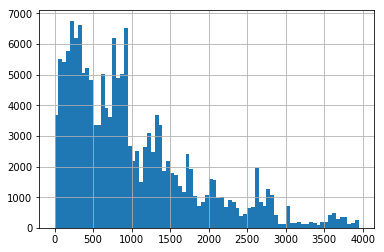

In [31]:
df_bus['density'].hist(bins=np.arange(0,4000,50))